<a href="https://colab.research.google.com/github/soutrik71/MInMaxBERT/blob/main/notebook/BertTextClassifier_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The objective of this notebook is to test out Simple and Complex Questions using a Base Bert Model:
* Focus on Tokenization part for the data
* Focus on model pre-training in pytorch
* Application of Focal loss in handling imbalanced data
* Application of adding weights to loss function for imbalanced class
* Evaluation Framework
* More homogenous and representative data

In [1]:
!pip install transformers datasets torcheval --upgrade --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00


In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torcheval.metrics import BinaryAccuracy,BinaryF1Score,BinaryPrecision,BinaryRecall,BinaryConfusionMatrix
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Data Loading from git repo

In [50]:
df1 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/classifier_data.csv")
df2 = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/maz_abiconnect_curated_question_list.csv")
df3  = pd.read_csv("https://raw.githubusercontent.com/soutrik71/MInMaxBERT/main/data/cpna_curated_list.csv")

In [51]:
final_df = pd.concat([df1, df2,df3], ignore_index=True)

In [52]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,Simple
1,logistics,what should beThe target average time in route (Depot to Depot),Simple
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,Simple
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,Simple
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",Simple


<Axes: xlabel='Domain', ylabel='count'>

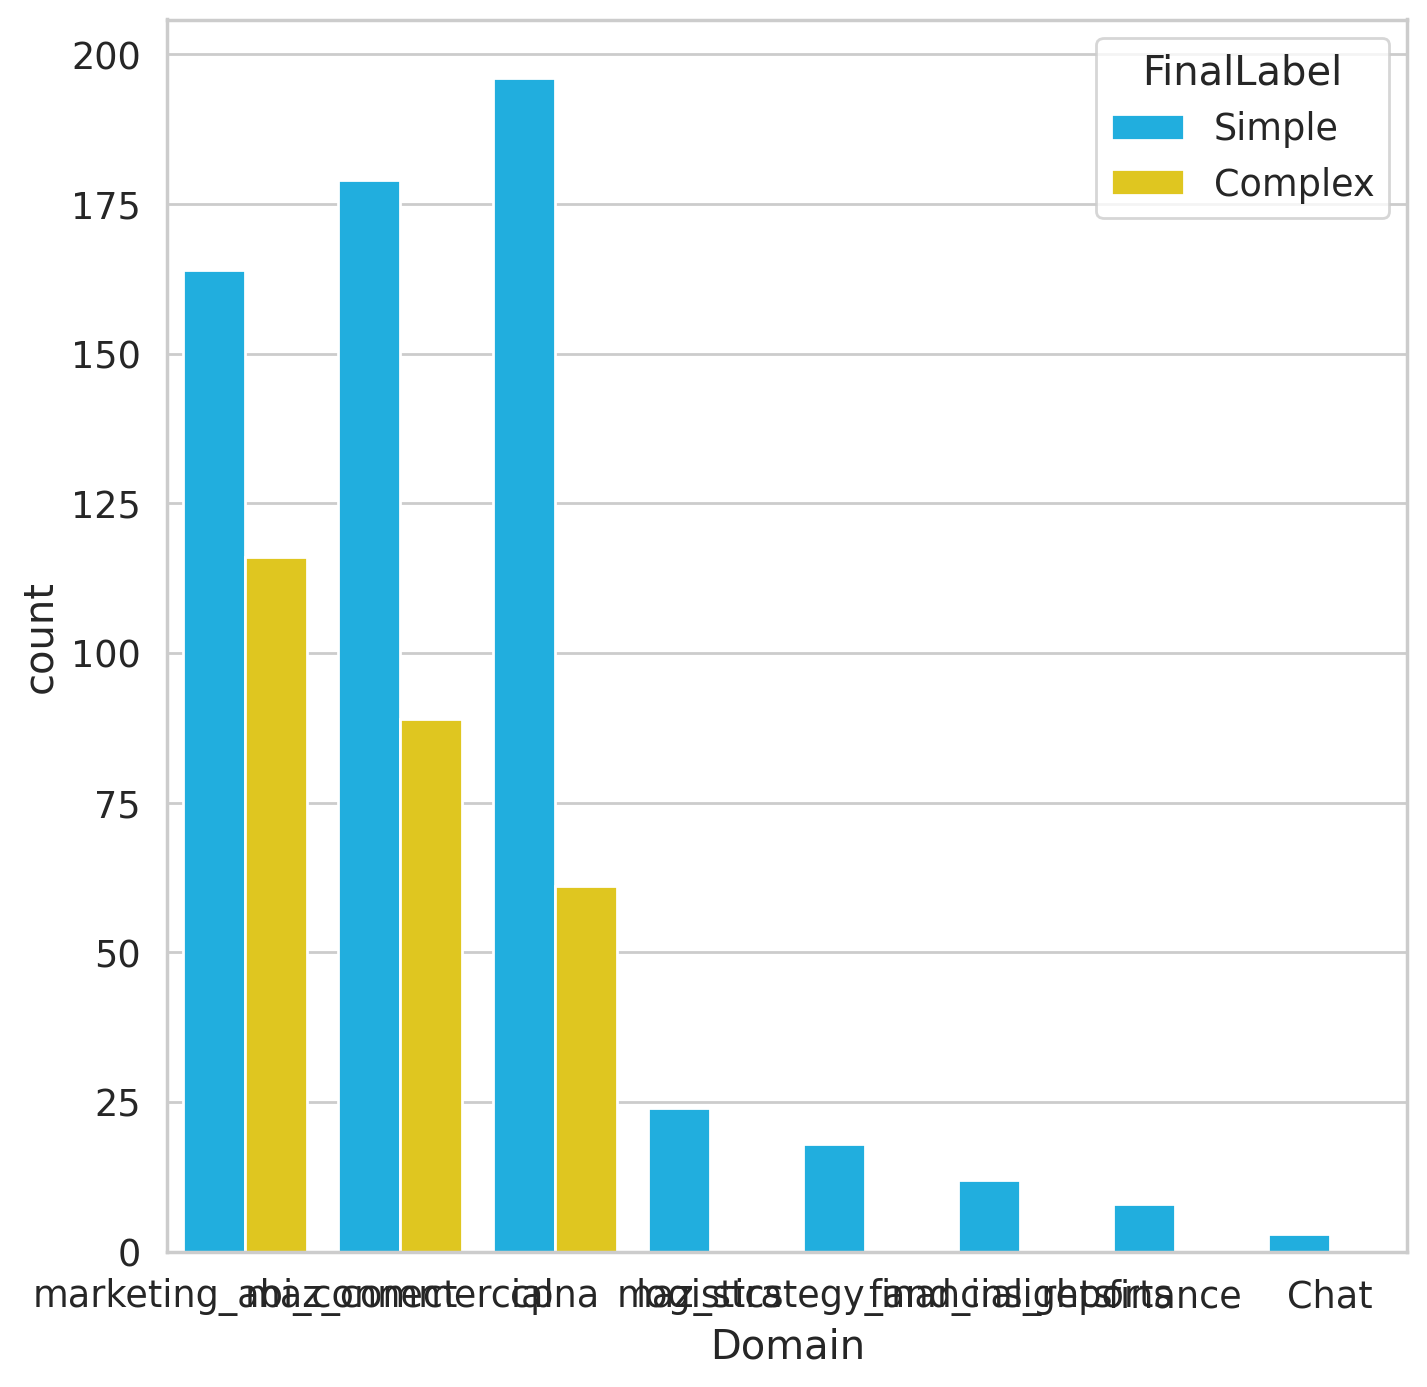

In [53]:
# @title Complex Questions by Domain

sns.countplot(x = final_df['Domain'], hue = final_df['FinalLabel'], order = final_df['Domain'].value_counts().index)

In [58]:
final_df["FinalLabel"].value_counts()

0    604
1    266
Name: FinalLabel, dtype: int64

In [57]:
final_df.isnull().sum()

Domain        0
Question      0
FinalLabel    0
dtype: int64

In [56]:
final_df["FinalLabel"] = final_df["FinalLabel"].apply(lambda x: x.upper()).map({"SIMPLE":0,"COMPLEX":1})
final_df["FinalLabel"] = final_df["FinalLabel"].astype(int)

In [9]:
final_df.head()

,Domain,Question,FinalLabel
0,logistics,What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?,0
1,logistics,what should beThe target average time in route (Depot to Depot),0
2,marketing_abi_connect,Which social media platform has the highest number of negative sentiments followed by male population for the above brands?,0
3,logistics,What Are Tools And Equipment Used In Truck Departure Process?,0
4,maz_commercial,"What is the net revenue per HL in Aug 2023, July 2023 and percentage change from July to Aug for the above brand?",0


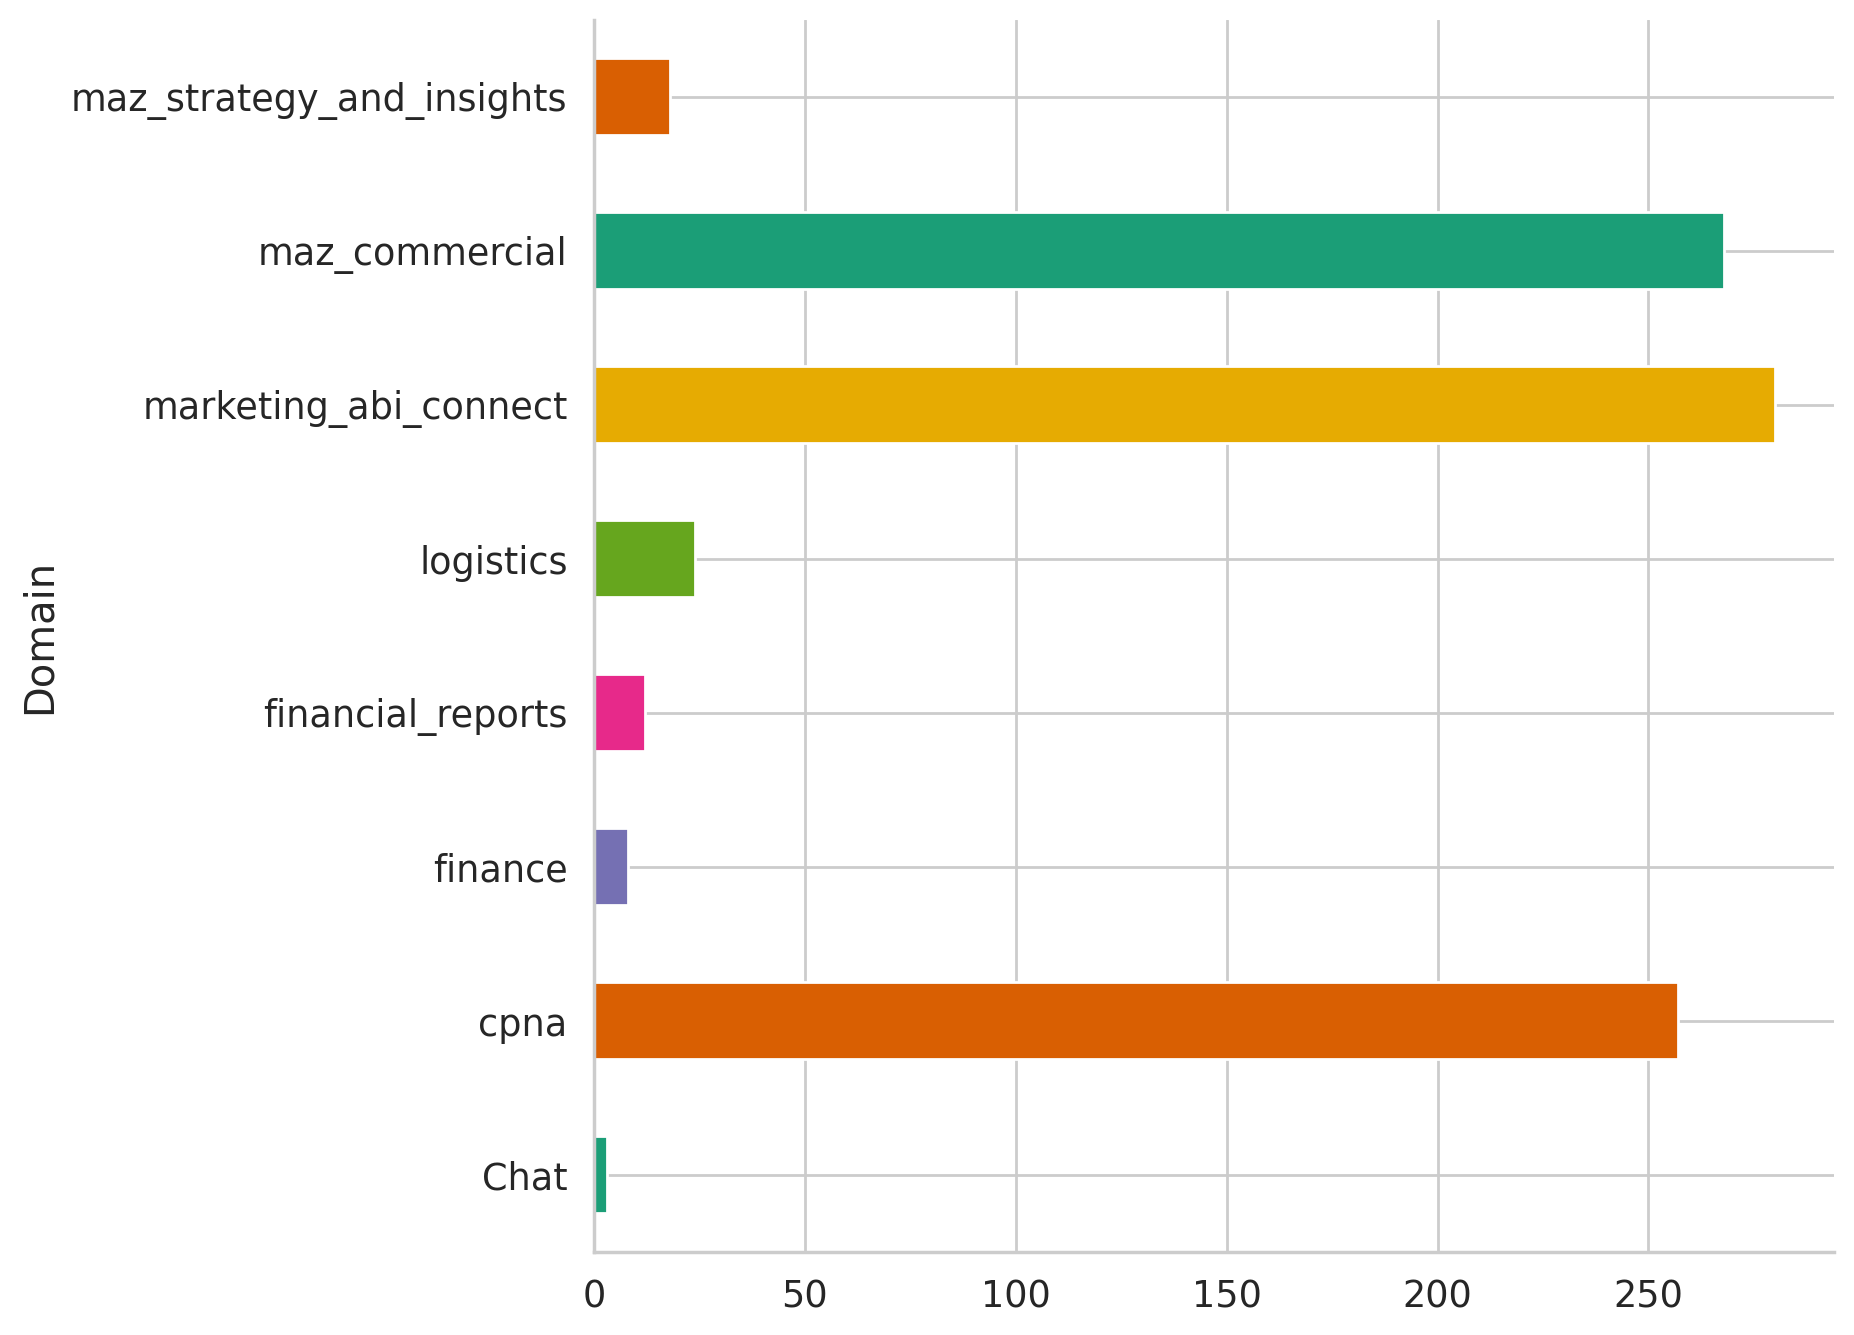

In [11]:
# @title Domain

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('Domain').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

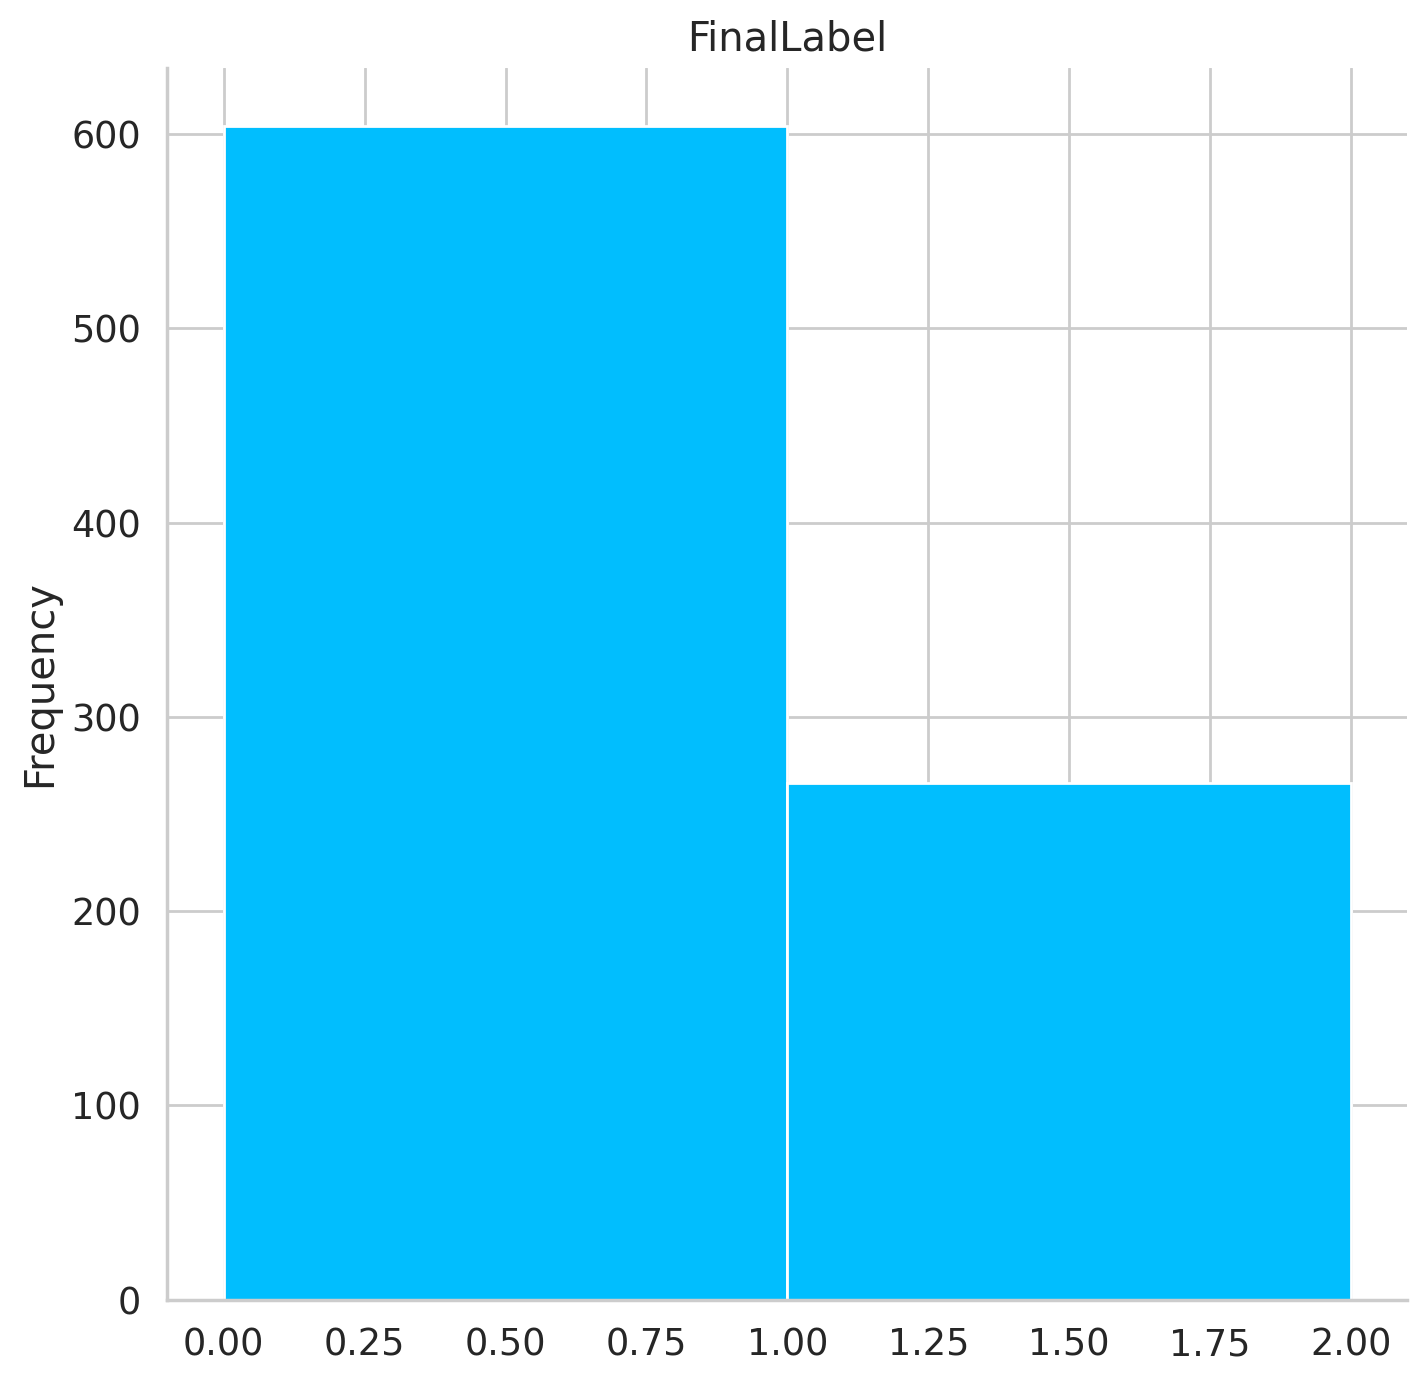

In [12]:
final_df['FinalLabel'].plot(kind='hist', bins=[0,1,2], title='FinalLabel')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [59]:
final_df.info(),"Null values",final_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 870 entries, 0 to 869
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Domain      870 non-null    object
 1   Question    870 non-null    object
 2   FinalLabel  870 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 20.5+ KB


(None,
 'Null values',
 Domain        0
 Question      0
 FinalLabel    0
 dtype: int64)

In [60]:
class_names = ['Simple', 'Complex']

In [61]:
final_df['FinalLabel'].value_counts()

0    604
1    266
Name: FinalLabel, dtype: int64

## Data Preprocessing using Bert tokenizer

In [62]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased' # cased means What is considered different to what ie case sensitive
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 10
learning_rate = 2e-05

In [63]:
sample_text = final_df["Question"].values[0]
print(sample_text)

What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?


We use tokenizer.encode_plus to do the follwing activities
1. Add speacila tokens like CLS[101] SEP[102] PADDING[0] and UNK[100] in the text
2. Tokenize the tokens with int encoding
3. Provide attention mask which confirms actual tokens and paddings

In [64]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [65]:
encoding = tokenizer.encode_plus(
  sample_text,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  truncation=True, # in case larger
  return_tensors='pt',  # Return PyTorch tensors
)

print(encoding.keys())

dict_keys(['input_ids', 'attention_mask'])


In [66]:
print(len(encoding['input_ids'][0]))
print(encoding['input_ids'].shape)
print(len(encoding['attention_mask'][0]))
print(encoding['attention_mask'].shape)

128
torch.Size([1, 128])
128
torch.Size([1, 128])


1 added dim is the batch size, which we have to remove while we call this within the custom torch dataset creation

## Training and evaluation dataprep

### Custom Pytorch Dataset creation

In [67]:
class QuestionClassficationDataset(Dataset):

  def __init__(self, question, targets, tokenizer, max_len):
    self.question = question
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.question)

  def __getitem__(self, item):
    review = str(self.question[item])
    if self.targets is not None:
      target = self.targets[item]

    # token encoder
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      truncation=True,
      return_tensors='pt',
    )

    if self.targets is not None:
      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'].squeeze(),
        'targets': torch.tensor(target, dtype=torch.float)
      }

    else:

      return {
        'review_text': review,
        'input_ids': encoding['input_ids'].squeeze(),
        'attention_mask': encoding['attention_mask'],
      }



In [68]:
sample_dataset = QuestionClassficationDataset(
  question=[final_df["Question"].values[0]],
  targets=[final_df["FinalLabel"].values[0]],
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [69]:
for ds in sample_dataset:
  print(ds.keys())

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])


In [70]:
next(iter(sample_dataset))

{'review_text': 'What is the percentage change in volume for same brand by different regions in August 2023 as compared previous month?',
 'input_ids': tensor([  101,  1327,  1110,  1103,  6556,  1849,  1107,  3884,  1111,  1269,
          4097,  1118,  1472,  4001,  1107,  1360, 17881,  1495,  1112,  3402,
          2166,  2370,   136,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,  

In [71]:
def create_data_loader(df, tokenizer, max_len, batch_size, shuffle):
  dataset = QuestionClassficationDataset(
    question=df["Question"].values,
    targets=df["FinalLabel"].values,
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=shuffle
  )

In [72]:
# startified train test split
train_df , test_df = train_test_split(final_df, test_size=0.25, random_state=42, stratify=final_df["FinalLabel"])
print(train_df.shape)
print(test_df.shape)

(652, 3)
(218, 3)


In [73]:
print(train_df["FinalLabel"].value_counts()/len(train_df))
print(test_df["FinalLabel"].value_counts()/len(test_df))

0    0.694785
1    0.305215
Name: FinalLabel, dtype: float64
0    0.692661
1    0.307339
Name: FinalLabel, dtype: float64


In [74]:
# train test dataloader
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE, True)
test_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE, False)

In [75]:
# batched of 8 with 128 token size
for sample_data in train_loader:
  print(sample_data.keys())
  print(sample_data["input_ids"].shape)
  print(sample_data["attention_mask"].shape)
  print(sample_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




In [76]:
for test_data in test_loader:
  print(test_data.keys())
  print(test_data["input_ids"].shape)
  print(test_data["attention_mask"].shape)
  print(test_data["targets"].shape)
  print("\n")
  break

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([8, 128])
torch.Size([8, 128])
torch.Size([8])




## Bert Classifier

In [77]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [78]:
bert_model_direct = BertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL_NAME, num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [79]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [80]:
bert_model_direct

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

The bert model gives you only 1 pooler with same 768 hidden units as input and output passed through a tanh activation function.

The bert_model_direct is a classfier which is build on top of the bert model with a linear classifier layer at the end

In [81]:
# application
op = bert_model(
  input_ids=sample_data['input_ids'],
  attention_mask=sample_data['attention_mask']
)

In [82]:
op['last_hidden_state'].shape

torch.Size([8, 128, 768])

In [83]:
op['pooler_output'].shape

torch.Size([8, 768])

* representation : 8 sentences with 128 tokens with each having a vector of dim 768
* Bert base has 12 sets of transformers where bert large has a set of 24
* For any downstream task we will use the pooler output

### Model Training

In [84]:
class BertSentimentClassifier(nn.Module):

  def __init__(self, n_classes, dropout = 0.1):
    super(BertSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    return self.classifier(output)

In [85]:
bert_base_classifier = BertSentimentClassifier(1).to(device)
bert_base_classifier

BertSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [86]:
# input_ids=sample_data['input_ids'].to(device)
# attention_mask=sample_data['attention_mask'].to(device)

# print(input_ids.shape) # batch size x seq length
# print(attention_mask.shape) # batch size x seq length

In [87]:
# model_op = bert_base_classifier(input_ids, attention_mask)
# print(model_op.squeeze().shape)
# print(sample_data["targets"].shape)

In [88]:
# device_setup-----
# loss
criterion = torch.nn.BCEWithLogitsLoss()
# optimizer
optimizer = AdamW(bert_base_classifier.parameters(), lr=learning_rate, correct_bias=False)
# scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# metrics
metric = BinaryF1Score(device = device)

In [89]:
def train_module(model:torch.nn.Module,
                 device:torch.device,
                 train_dataloader:torch.utils.data.DataLoader ,
                 optimizer:torch.optim.Optimizer,
                 criterion:torch.nn.Module,
                 metric,
                 scheduler,
                 train_losses:list,
                 train_metrics:list):

  # setting model to train mode
  model.train()
  pbar = tqdm(train_dataloader)

  # batch metrics
  train_loss = 0
  train_metric = 0
  processed_batch = 0

  for _,data in enumerate(pbar):

    ids = data['input_ids'].to(device)
    mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    # print(f"The target shape is {targets.shape}")

    # model output
    outputs = model(ids, mask)
    outputs = outputs.flatten()
    # print(f"The output shape is {outputs.shape}")

    # calc loss
    loss = criterion(outputs, targets)
    train_loss += loss.item()
    # print(f"training loss for batch {idx} is {loss}")

    # backpropagation
    optimizer.zero_grad() # flush out  existing grads
    loss.backward() # back prop of weights wrt loss
    # gradient clipping -- prevent gradient explosion
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # improvement steps
    optimizer.step() # optimizer step -> minima
    if scheduler is not None:
      scheduler.step() # scheduler step -> lr scheduling

    # metric calc
    metric.update(outputs,targets)
    train_metric += metric.compute().detach().item()

    #updating batch count
    processed_batch += 1

    pbar.set_description(f"Avg Train Loss: {train_loss/processed_batch} Avg Train Metric: {train_metric/processed_batch}")

  # It's typically called after the epoch completes
  metric.reset()
  # updating epoch metrics
  train_losses.append(train_loss/processed_batch)
  train_metrics.append(train_metric/processed_batch)

  return train_losses, train_metrics


In [90]:
def test_module(model:torch.nn.Module,
                device:torch.device,
                test_dataloader:torch.utils.data.DataLoader,
                criterion:torch.nn.Module,
                metric,
                test_losses,
                test_metrics):
  # setting model to eval mode
  model.eval()
  pbar = tqdm(test_dataloader)

  # batch metrics
  test_loss = 0
  test_metric = 0
  processed_batch = 0

  with torch.inference_mode():
    for _, data in enumerate(pbar, 0):
      ids = data['input_ids'].to(device)
      mask = data['attention_mask'].to(device)
      targets = data['targets'].to(device)

      # print(f"The target shape is {targets.shape}")

      # model output
      outputs = model(ids, mask)
      outputs = outputs.flatten()

      # print(f"The output shape is {outputs.shape}")

     # calc loss
      loss = criterion(outputs, targets)
      test_loss += loss.item()

      # metric calc
      metric.update(outputs, targets)
      test_metric += metric.compute().detach().item()

      #updating batch count
      processed_batch += 1

      pbar.set_description(f"Avg Test Loss: {test_loss/processed_batch} Avg Test Metric: {test_metric/processed_batch}")

    # It's typically called after the epoch completes
    metric.reset()
    # updating epoch metrics
    test_losses.append(test_loss/processed_batch)
    test_metrics.append(test_metric/processed_batch)

  return test_losses, test_metrics

In [91]:
%%time

train_losses = []
train_metrics = []
test_losses = []
test_metrics = []

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_losses, train_metrics = train_module(
      model = bert_base_classifier,
      device = device,
      train_dataloader = train_loader,
      optimizer = optimizer,
      criterion = criterion,
      metric = metric,
      scheduler = scheduler,
      train_losses = train_losses,
      train_metrics = train_metrics,
  )

  test_losses, test_metrics = test_module(
      model = bert_base_classifier,
      device = device,
      test_dataloader = test_loader,
      criterion = criterion,
      metric = metric,
      test_losses = test_losses,
      test_metrics = test_metrics,
  )

  print(f"The learing rate is {scheduler.get_last_lr()}")


Epoch 1/10
----------


Avg Train Loss: 0.4098349318544312 Avg Train Metric: 0.37605711322550367: 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]
Avg Test Loss: 0.20130368767838394 Avg Test Metric: 0.9062236739056451: 100%|██████████| 28/28 [00:01<00:00, 14.21it/s]


The learing rate is [1.8e-05]
Epoch 2/10
----------


Avg Train Loss: 0.19642843946632815 Avg Train Metric: 0.8570051985542949: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]
Avg Test Loss: 0.16399063120063925 Avg Test Metric: 0.9483653498547417: 100%|██████████| 28/28 [00:01<00:00, 14.78it/s]


The learing rate is [1.6000000000000003e-05]
Epoch 3/10
----------


Avg Train Loss: 0.171660875966886 Avg Train Metric: 0.9514937226365252: 100%|██████████| 82/82 [00:17<00:00,  4.79it/s]
Avg Test Loss: 0.12028169350898159 Avg Test Metric: 0.9753951707056591: 100%|██████████| 28/28 [00:01<00:00, 15.83it/s]


The learing rate is [1.4e-05]
Epoch 4/10
----------


Avg Train Loss: 0.14080725376857672 Avg Train Metric: 0.9425134775115223: 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]
Avg Test Loss: 0.31268853507936 Avg Test Metric: 0.8935952335596085: 100%|██████████| 28/28 [00:01<00:00, 15.91it/s]


The learing rate is [1.2e-05]
Epoch 5/10
----------


Avg Train Loss: 0.10088705437019377 Avg Train Metric: 0.9539289481756164: 100%|██████████| 82/82 [00:16<00:00,  4.92it/s]
Avg Test Loss: 0.14707697958718718 Avg Test Metric: 0.9472332894802094: 100%|██████████| 28/28 [00:01<00:00, 15.81it/s]


The learing rate is [1e-05]
Epoch 6/10
----------


Avg Train Loss: 0.06314047099028645 Avg Train Metric: 0.974156495274567: 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]
Avg Test Loss: 0.1531810105994477 Avg Test Metric: 0.9517986859594073: 100%|██████████| 28/28 [00:01<00:00, 15.55it/s]


The learing rate is [8.000000000000001e-06]
Epoch 7/10
----------


Avg Train Loss: 0.04937603528378531 Avg Train Metric: 0.9641552036855279: 100%|██████████| 82/82 [00:17<00:00,  4.80it/s]
Avg Test Loss: 0.17156431267462072 Avg Test Metric: 0.9403866870062692: 100%|██████████| 28/28 [00:01<00:00, 15.58it/s]


The learing rate is [6e-06]
Epoch 8/10
----------


Avg Train Loss: 0.03614846642679966 Avg Train Metric: 0.9843323899478447: 100%|██████████| 82/82 [00:17<00:00,  4.82it/s]
Avg Test Loss: 0.1881339296607101 Avg Test Metric: 0.9388094948870795: 100%|██████████| 28/28 [00:01<00:00, 15.85it/s]


The learing rate is [4.000000000000001e-06]
Epoch 9/10
----------


Avg Train Loss: 0.028362551194377153 Avg Train Metric: 0.984670069159531: 100%|██████████| 82/82 [00:16<00:00,  4.84it/s]
Avg Test Loss: 0.20062541015171778 Avg Test Metric: 0.9403866870062692: 100%|██████████| 28/28 [00:01<00:00, 15.21it/s]


The learing rate is [2.0000000000000003e-06]
Epoch 10/10
----------


Avg Train Loss: 0.027078722964222656 Avg Train Metric: 0.9976389975082584: 100%|██████████| 82/82 [00:16<00:00,  4.84it/s]
Avg Test Loss: 0.1938850926131376 Avg Test Metric: 0.9403866870062692: 100%|██████████| 28/28 [00:01<00:00, 15.63it/s]

The learing rate is [0.0]
CPU times: user 2min 19s, sys: 45.7 s, total: 3min 4s
Wall time: 3min 8s


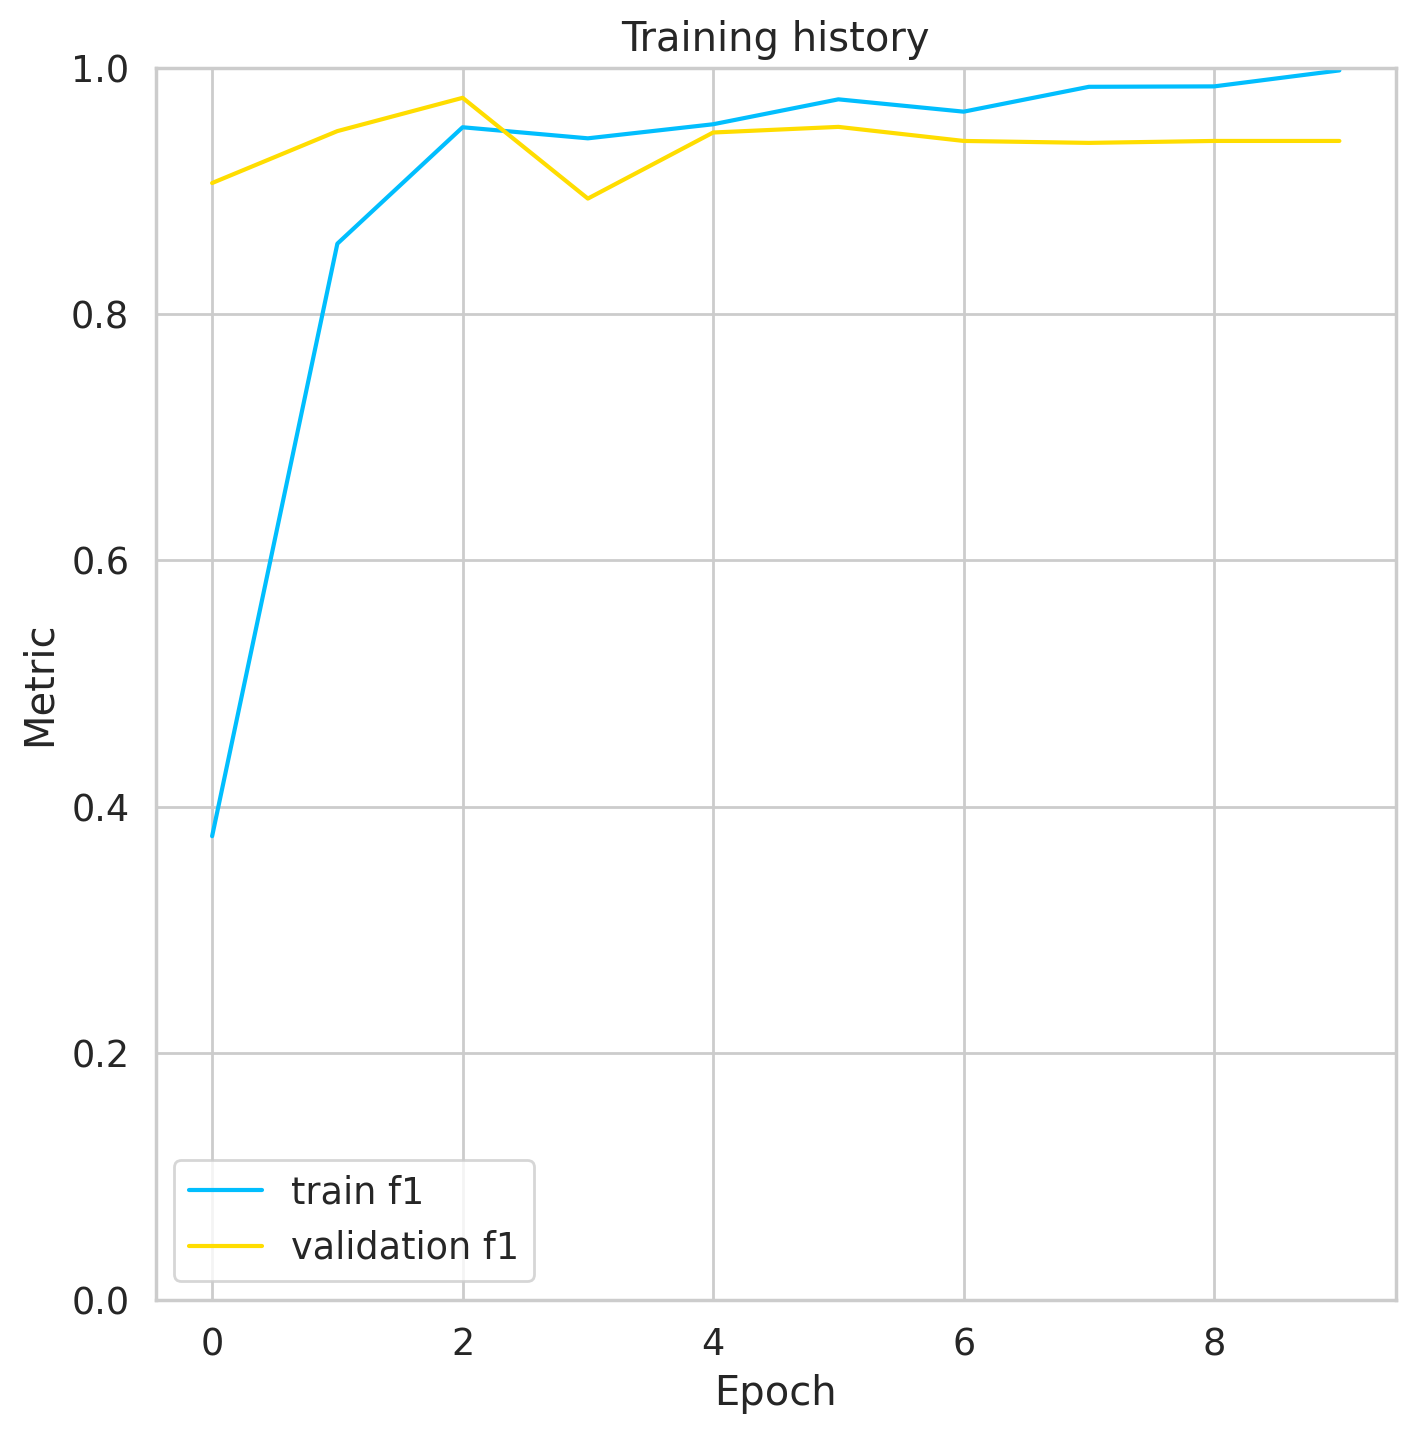

In [92]:
plt.plot(train_metrics, label='train f1')
plt.plot(test_metrics ,label='validation f1')

plt.title('Training history')
plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Evalutaion Framework

In [93]:
def get_predictions(model, data_loader):

  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  model.eval()
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      ).flatten()

      probs = torch.sigmoid(outputs)
      preds = torch.round(probs)


      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()

  return review_texts, predictions, prediction_probs

In [94]:
raw_sentences = ["What was the sales for brand Hurricane in India?",
                 "How did the sales for brand X varied over last one year?",
                 "Explain how has the impact on water shortage on the production of beer in India?",
                 "How is the performance of Classic lager segment in LP TY compared to LP YA?",
                 "Detail the reasons for drop in sales for brand Corona in the west?",
                 "How did the sales evolved for brand Jupiter over the period of last 6 months?"]

In [95]:
eval_dataset = QuestionClassficationDataset(
  question=raw_sentences,
  targets=None,
  tokenizer=tokenizer,
  max_len=MAX_LEN
)

In [96]:
eval_dataloader = DataLoader(
  eval_dataset,
  batch_size=1,
  shuffle=False
)

In [97]:
review_texts, predictions, prediction_probs = get_predictions(bert_base_classifier , eval_dataloader)

In [98]:
predictions

tensor([0., 0., 1., 1., 1., 0.])

In [99]:
prediction_probs

tensor([0.0011, 0.0017, 0.9996, 0.9985, 0.9997, 0.0024])

1. Application of Focal loss for unbalanced data
2. application of weights in loss functions
3. A bit more conservative model to tackle overfitting
4. Assure the data to be hetergenous ie use embedding and cosine sim

## Application of a conservative Model

In [ ]:
class BertSentimentClassifierExtended(nn.Module):

  def __init__(self, n_classes, fc_hidden = 128 , dropout = 0.1):
    super(BertSentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=dropout)
    self.pooler = nn.Linear(self.bert.config.hidden_size, fc_hidden)
    self.classifier = nn.Linear(fc_hidden n_classes)


  def forward(self, input_ids, attention_mask):

    model_op = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    pooled_output = model_op['pooler_output']
    output = self.drop(pooled_output)
    output = self.pooler(output)
    output = nn.BatchNorm1d(output)
    return self.classifier(output)